In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix as csr
from scipy.sparse import lil_matrix as lil
from scipy.sparse import kron
from scipy.sparse.linalg import eigs, eigsh
import timeit
import scipy.sparse as sps
from numpy import linalg as LA

# Infinite DMRG

In [2]:
bc = 0 #boundary condition
t = 1
U = 0.2

n_kept_states = 10 # Number of states kept


# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 34
system_size = 2*n_iter+2 # number of unit cells (sites = 2*system_size)


###########################################################
# Operators in 2 dimensional hilbert space for single site
###########################################################

# Creation and Annihilation Operators:
C = csr(np.array([[0,0],[1,0]])) #annihilation operator -> sigma_minus
C_dag = csr(np.transpose(C)) #creation operator -> sigma_plus

# Number Operator:
n = C_dag*C

#Identity matrix
I_d = csr(np.eye(2))
I = csr(np.eye(4))

#Sigma_z
#z = csr(np.array([[1,0],[0,-1]]))

############################################################################
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
############################################################################

#Each site is considered to be a unitcell that the left side is spin-down and the right side is spin-up

C_up = csr(kron(I_d,C))       #second site in unitcell
C_down = csr(kron(C,I_d))   #first site in unitcell

C_up_dag = csr.transpose(C_up)
C_down_dag = csr.transpose(C_down)

n_up = csr(kron(I_d,n))
n_down = csr(kron(n,I_d))

#Z = kron(z,z)

# Operators for last site added to block 
block_Cu_last = C_up
block_Cud_last = C_up_dag
block_Cd_last = C_down
block_Cdd_last = C_down_dag
block_nu_last = n_up
block_nd_last = n_down
block_Id  = kron(I_d,I_d)
#block_Z = Z

# one site Hamiltonian
block_H = U*(n_up*n_down)

# initializing a few useful quantities:
EE = np.zeros(n_iter)
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)

# Saving operators for finite dmrg

block_Cu_list = []
block_Cud_list = []

block_Cd_list = []
block_Cdd_list = []

block_H_list = []
block_Id_list = []

#block_Z_list = []

block_Cu_list.append(block_Cu_last)
block_Cud_list.append(block_Cud_last)

block_Cd_list.append(block_Cd_last)
block_Cdd_list.append(block_Cdd_last)

block_H_list.append(block_H)
block_Id_list.append(block_Id)

#block_Z_list.append(block_Z)

In [3]:
###############################
#   Begin main iterations
###############################

start = timeit.default_timer()
for l in range(1,n_iter+1):
    
    ##################################################################
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    ##################################################################
    
    block_nu_last = kron(block_Id,n_up)
    block_nd_last = kron(block_Id,n_down)

    block_H = kron(block_H,I)-t*(kron(block_Cud_last,C_up) + kron(block_Cu_last,C_up_dag)\
                                 + kron(block_Cdd_last,C_down)+ kron(block_Cd_last,C_down_dag))\
    + U*(block_nu_last*block_nd_last)
    
    block_Cu_last = kron(block_Id,C_up)
    block_Cud_last = kron(block_Id,C_up_dag)
    block_Cd_last = kron(block_Id,C_down)
    block_Cdd_last = kron(block_Id,C_down_dag)
    block_Id = kron(block_Id,I)
    
    
    H_superblock = kron(block_H,block_Id) + kron(block_Id, block_H)\
    -t*(kron(block_Cud_last,block_Cu_last) + kron(block_Cu_last,block_Cud_last)\
        + kron(block_Cdd_last,block_Cd_last) + kron(block_Cd_last,block_Cdd_last))
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2  
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    #last_energy = energy
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l-1] = energy/(l * 2 + 2)
    system_size[l-1] = 2*(l+1)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block = np.size(block_H,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block, dim_block))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix))
    
    #########################################################################
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #########################################################################
    
    n_kept_temp = min(dim_block, n_kept_states)
    D, V = LA.eigh(block_Rho)
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    ES = D
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l-1] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l-1] = 1 - sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l-1], truncation_error[l-1]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    if l < n_iter:
        block_H  = block_T_dag*block_H*block_T
        block_Cu_last  = block_T_dag*block_Cu_last*block_T
        block_Cud_last = block_T_dag*block_Cud_last*block_T
        block_Cd_last = block_T_dag*block_Cd_last*block_T
        block_Cdd_last = block_T_dag*block_Cdd_last*block_T
        block_Id = block_T_dag*block_Id*block_T
        block_nu_last = block_T_dag*block_nu_last*block_T
        block_nd_last = block_T_dag*block_nd_last*block_T  
        
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list.append(block_Cu_last)
    block_Cud_list.append(block_Cud_last)

    block_Cd_list.append(block_Cd_last)
    block_Cdd_list.append(block_Cdd_last)

    block_H_list.append(block_H)
    block_Id_list.append(block_Id)
    
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 1	 total_En: -4.2763	 En_per_bound: -1.0691	 trunErr: 0.0027
iter: 2	 total_En: -6.6625	 En_per_bound: -1.1104	 trunErr: 0.0031
iter: 3	 total_En: -9.0581	 En_per_bound: -1.1323	 trunErr: 0.0038
iter: 4	 total_En: -11.4524	 En_per_bound: -1.1452	 trunErr: 0.0048
iter: 5	 total_En: -13.8504	 En_per_bound: -1.1542	 trunErr: 0.0035
iter: 6	 total_En: -16.2501	 En_per_bound: -1.1607	 trunErr: 0.0047
iter: 7	 total_En: -18.6508	 En_per_bound: -1.1657	 trunErr: 0.0032
iter: 8	 total_En: -21.0539	 En_per_bound: -1.1697	 trunErr: 0.0045
iter: 9	 total_En: -23.4565	 En_per_bound: -1.1728	 trunErr: 0.0031
iter: 10	 total_En: -25.8617	 En_per_bound: -1.1755	 trunErr: 0.0044
iter: 11	 total_En: -28.2660	 En_per_bound: -1.1777	 trunErr: 0.0030
iter: 12	 total_En: -30.6725	 En_per_bound: -1.1797	 trunErr: 0.0043
iter: 13	 total_En: -33.0782	 En_per_bound: -1.1814	 trunErr: 0.0030
iter: 14	 total_En: -35.4856	 En_per_bound: -1.1829	 trunErr: 0.0041
iter: 15	 total_En: -37.8925	 En_per_bound: -1

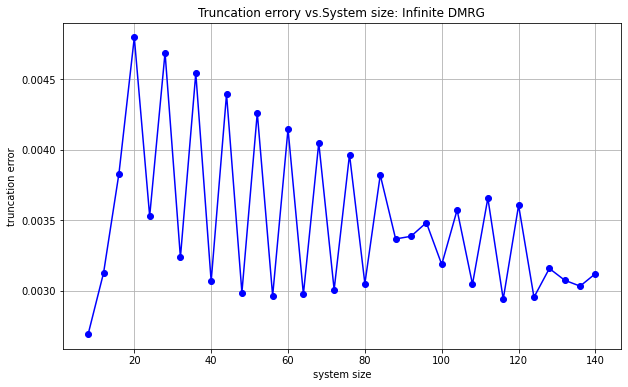

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot(2*system_size,truncation_error,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('truncation error')
plt.title('Truncation errory vs.System size: Infinite DMRG')
plt.grid('on')

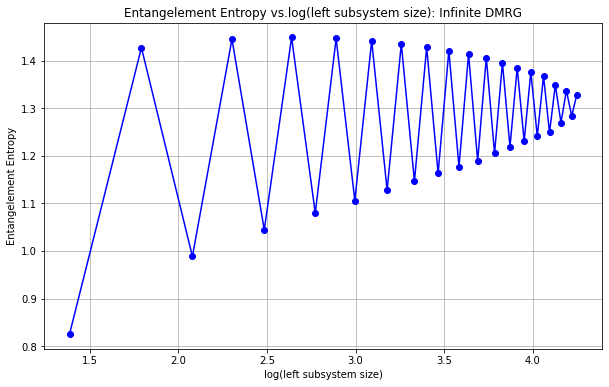

In [5]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(system_size),EE,'o-',c='b')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Infinite DMRG')
plt.grid('on')

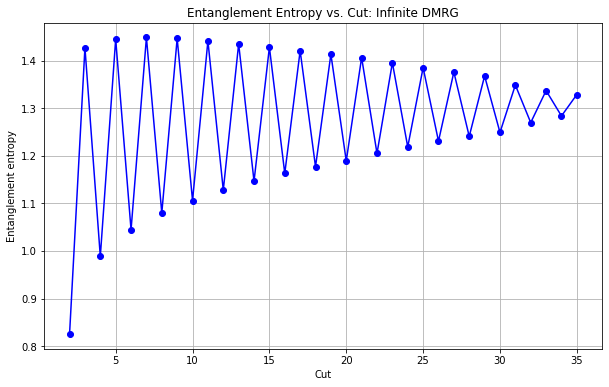

In [6]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='b')
plt.title('Entanglement Entropy vs. Cut: Infinite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')

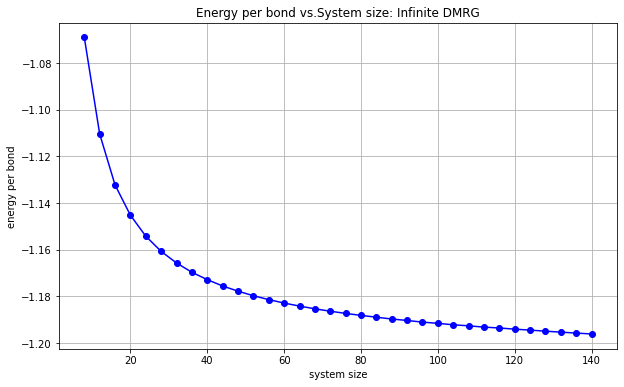

In [7]:
fig = plt.figure(figsize=(10,6))
plt.plot(2*system_size,energy_per_bond,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('energy per bond')
plt.title('Energy per bond vs.System size: Infinite DMRG')
plt.grid('on')

# Finite DMRG

In [8]:
#Loading operators for left block:
block_Cu_left = block_Cu_list[n_iter]
block_Cud_left = block_Cud_list[n_iter]

block_Cd_left = block_Cd_list[n_iter]
block_Cdd_left = block_Cdd_list[n_iter]

block_H_left = block_H_list[n_iter]
block_Id_left = block_Id_list[n_iter]

# DMRG Sweeps

### Left-to-Right Sweep

In [9]:
system_size = 2*n_iter + 2

###############################
#   Begin main iterations
###############################
n_iter_l = n_iter-1 #because there are already two sites in the system

truncation_error = np.zeros(n_iter_l)
energy_per_bond = np.zeros(n_iter_l)

start = timeit.default_timer()
for l in range(1,n_iter_l+1):
    
    ###########################
    #  Right block operators
    ###########################
    
    #Shrink the right block using the operators from infinite dmrg:
    block_H_right = block_H_list[n_iter - (l+1)]
    
    block_Cu_right = block_Cu_list[n_iter - (l+1)]
    block_Cud_right = block_Cud_list[n_iter - (l+1)]
    
    block_Cd_right = block_Cd_list[n_iter - (l+1)]
    block_Cdd_right = block_Cdd_list[n_iter - (l+1)]
    
    block_Id_right = block_Id_list[n_iter - (l+1)]
  
    #constructing the right block hamiltonian
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)
    
    ##############################
    #  Adding site to left block
    ##############################
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)
 
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2 #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l-1] = energy/system_size

    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix)) #reduced density matrix
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)

    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1] 
    V = V[:, sort_ind] 
    D = D[sort_ind]
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp] #truncation operator
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l-1] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l-1], truncation_error[l-1]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_left  = block_T_dag*block_H_left*block_T
    block_Cu_left  = block_T_dag*block_Cu_left*block_T
    block_Cud_left = block_T_dag*block_Cud_left*block_T
    block_Cd_left = block_T_dag*block_Cd_left*block_T
    block_Cdd_left = block_T_dag*block_Cdd_left*block_T
    block_Id_left = block_T_dag*block_Id_left*block_T
    
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list.append(block_Cu_left)
    block_Cud_list.append(block_Cud_left)

    block_Cd_list.append(block_Cd_left)
    block_Cdd_list.append(block_Cdd_left)

    block_H_list.append(block_H_left)
    block_Id_list.append(block_Id_left)
    
    
stop = timeit.default_timer()
print('Time: ', stop - start)     

iter: 1	 total_En: -83.7363	 En_per_bound: -1.1962	 trunErr: 0.0034
iter: 2	 total_En: -83.7364	 En_per_bound: -1.1962	 trunErr: 0.0037
iter: 3	 total_En: -83.7357	 En_per_bound: -1.1962	 trunErr: 0.0031
iter: 4	 total_En: -83.7352	 En_per_bound: -1.1962	 trunErr: 0.0031
iter: 5	 total_En: -83.7366	 En_per_bound: -1.1962	 trunErr: 0.0032
iter: 6	 total_En: -83.7354	 En_per_bound: -1.1962	 trunErr: 0.0028
iter: 7	 total_En: -83.7419	 En_per_bound: -1.1963	 trunErr: 0.0032
iter: 8	 total_En: -83.7407	 En_per_bound: -1.1963	 trunErr: 0.0028
iter: 9	 total_En: -83.7471	 En_per_bound: -1.1964	 trunErr: 0.0032
iter: 10	 total_En: -83.7460	 En_per_bound: -1.1964	 trunErr: 0.0029
iter: 11	 total_En: -83.7524	 En_per_bound: -1.1965	 trunErr: 0.0033
iter: 12	 total_En: -83.7513	 En_per_bound: -1.1964	 trunErr: 0.0029
iter: 13	 total_En: -83.7575	 En_per_bound: -1.1965	 trunErr: 0.0034
iter: 14	 total_En: -83.7566	 En_per_bound: -1.1965	 trunErr: 0.0030
iter: 15	 total_En: -83.7623	 En_per_bound:

In [10]:
#Loading operators for right block:
block_Cu_right = block_Cu_list[0]
block_Cud_right = block_Cud_list[0]

block_Cd_right = block_Cd_list[0]
block_Cdd_right = block_Cdd_list[0]

block_H_right = block_H_list[0]
block_Id_right = block_Id_list[0]

### Right-to-Left Sweep

In [11]:
n_iter_r = 2*n_iter_l+1 #from last sweep

truncation_error = np.zeros(n_iter_r)
energy_per_bond = np.zeros(n_iter_r)

###############################
#   Begin main iterations
###############################

start = timeit.default_timer()
for l in range(1,n_iter_r+1):
    
    #########################
    #  Left block operators
    #########################
    
    # using the left block operators from the privious left to right sweep:
    
    block_H_left = block_H_list[n_iter_r - l]
    
    block_Cu_left = block_Cu_list[n_iter_r - l]
    block_Cud_left = block_Cud_list[n_iter_r - l]
    
    block_Cd_left = block_Cd_list[n_iter_r - l]
    block_Cdd_left = block_Cdd_list[n_iter_r - l]
    
    block_Id_left = block_Id_list[n_iter_r - l]
  
    #Left block hamiltonian:
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)
    
    #########################################################
    #  Adding site to right block & right block hamiltonian
    #########################################################
    
    #Right block hamiltonian:
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)

    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2 #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l-1] = energy/system_size

    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(np.transpose(Psi_matrix),Psi_matrix)
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)
    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l-1] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l-1], truncation_error[l-1]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_right  = block_T_dag*block_H_right*block_T
    
    block_Cu_right  = block_T_dag*block_Cu_right*block_T
    block_Cud_right = block_T_dag*block_Cud_right*block_T
    
    block_Cd_right = block_T_dag*block_Cd_right*block_T
    block_Cdd_right = block_T_dag*block_Cdd_right*block_T
    
    block_Id_right = block_T_dag*block_Id_right*block_T
    
    ###################################
    # Saving operators for finite dmrg
    ###################################
    
    block_Cu_list[l] = block_Cu_right
    block_Cud_list[l] = block_Cud_right

    block_Cd_list[l] = block_Cd_right
    block_Cdd_list[l] = block_Cdd_right

    block_H_list[l] = block_H_right
    block_Id_list[l] = block_Id_right
    
stop = timeit.default_timer()
print('Time: ', stop - start)       

iter: 1	 total_En: -83.8066	 En_per_bound: -1.1972	 trunErr: 0.0024
iter: 2	 total_En: -83.8067	 En_per_bound: -1.1972	 trunErr: 0.0034
iter: 3	 total_En: -83.8086	 En_per_bound: -1.1973	 trunErr: 0.0029
iter: 4	 total_En: -83.8089	 En_per_bound: -1.1973	 trunErr: 0.0040
iter: 5	 total_En: -83.8097	 En_per_bound: -1.1973	 trunErr: 0.0030
iter: 6	 total_En: -83.8099	 En_per_bound: -1.1973	 trunErr: 0.0038
iter: 7	 total_En: -83.8129	 En_per_bound: -1.1973	 trunErr: 0.0033
iter: 8	 total_En: -83.8103	 En_per_bound: -1.1973	 trunErr: 0.0034
iter: 9	 total_En: -83.8146	 En_per_bound: -1.1974	 trunErr: 0.0035
iter: 10	 total_En: -83.8113	 En_per_bound: -1.1973	 trunErr: 0.0032
iter: 11	 total_En: -83.8164	 En_per_bound: -1.1974	 trunErr: 0.0036
iter: 12	 total_En: -83.8123	 En_per_bound: -1.1973	 trunErr: 0.0030
iter: 13	 total_En: -83.8182	 En_per_bound: -1.1974	 trunErr: 0.0036
iter: 14	 total_En: -83.8157	 En_per_bound: -1.1974	 trunErr: 0.0028
iter: 15	 total_En: -83.8229	 En_per_bound:

### Re-iterate left to right sweep

In [12]:
#Loading operators left operators:
block_Cu_left = block_Cu_list[0]
block_Cud_left = block_Cud_list[0]

block_Cd_left = block_Cd_list[0]
block_Cdd_left = block_Cdd_list[0]

block_H_left = block_H_list[0]
block_Id_left = block_Id_list[0]

In [13]:
truncation_error = np.zeros(n_iter_r)
energy_per_bond = np.zeros(n_iter_r)
EE = np.zeros(n_iter_r)
System_Size = np.zeros(n_iter_r)

for l in range(1,n_iter_r+1):
    
    ###########################
    #  Right block operators
    ###########################
    
    # using the right block from the privious right to left sweep:
    block_H_right = block_H_list[n_iter_r - l]
    
    block_Cu_right = block_Cu_list[n_iter_r - l]
    block_Cud_right = block_Cud_list[n_iter_r - l]
    
    block_Cd_right = block_Cd_list[n_iter_r - l]
    block_Cdd_right = block_Cdd_list[n_iter_r - l]
    
    block_Id_right = block_Id_list[n_iter_r - l]
    
    block_nu_right = kron(block_Id_right,n_up)
    block_nd_right = kron(block_Id_right,n_down)
    
    block_H_right = kron(block_H_right, I) -t*(kron(block_Cud_right,C_up) + kron(block_Cu_right,C_up_dag)\
                                              + kron(block_Cdd_right,C_down) + kron(block_Cd_right,C_down_dag))\
    + U*(block_nu_right*block_nd_right)
    
    block_Cu_right = kron(block_Id_right,C_up)
    block_Cud_right = kron(block_Id_right,C_up_dag)
    
    block_Cd_right = kron(block_Id_right,C_down)
    block_Cdd_right = kron(block_Id_right,C_down_dag)
    
    block_Id_right = kron(block_Id_right,I)
    
    ##############################
    #  Adding site to left block
    ##############################
    
    block_nu_left = kron(block_Id_left,n_up)
    block_nd_left = kron(block_Id_left,n_down)
    
    block_H_left = kron(block_H_left, I) -t*(kron(block_Cud_left,C_up) + kron(block_Cu_left,C_up_dag)\
                                              + kron(block_Cdd_left,C_down) + kron(block_Cd_left,C_down_dag))\
    + U*(block_nu_left*block_nd_left)
    
    block_Cu_left = kron(block_Id_left,C_up)
    block_Cud_left = kron(block_Id_left,C_up_dag)
    
    block_Cd_left = kron(block_Id_left,C_down)
    block_Cdd_left = kron(block_Id_left,C_down_dag)
    
    block_Id_left = kron(block_Id_left,I)

    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right)\
    -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right)\
       +kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
    
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2  #making sure hamiltonian is hermitian
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l-1] = energy/ system_size
    System_Size[l-1] = 2*(1+l)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block_left = np.size(block_H_left,axis=1)
    dim_block_right = np.size(block_H_right,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block_left, dim_block_right))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix))
    
    #######################################
    #   Diagonalize the density matrix 
    #######################################
    
    D, V = LA.eigh(block_Rho)
    #sorting eigenvalues and their corresponding eigenvectors in descending order:
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    ES = D
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l-1] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    n_kept_temp = min(len(D), n_kept_states)
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l-1] = 1 - sum(D[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l-1], truncation_error[l-1]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    block_H_left  = block_T_dag*block_H_left*block_T
    
    block_Cu_left  = block_T_dag*block_Cu_left*block_T
    block_Cud_left = block_T_dag*block_Cud_left*block_T
    
    block_Cd_left = block_T_dag*block_Cd_left*block_T
    block_Cdd_left = block_T_dag*block_Cdd_left*block_T
    
    block_Id_left = block_T_dag*block_Id_left*block_T
    
    #######################
    #   Save Operators 
    #######################
    block_Cu_list[l] = block_Cu_left
    block_Cud_list[l] = block_Cud_left

    block_Cd_list[l] = block_Cd_left
    block_Cdd_list[l] = block_Cdd_left

    block_H_list[l] = block_H_left
    block_Id_list[l] = block_Id_left
    
stop = timeit.default_timer()
print('Time: ', stop - start)  

iter: 1	 total_En: -83.9639	 En_per_bound: -1.1995	 trunErr: 0.0023
iter: 2	 total_En: -83.9629	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 3	 total_En: -83.9660	 En_per_bound: -1.1995	 trunErr: 0.0030
iter: 4	 total_En: -83.9637	 En_per_bound: -1.1995	 trunErr: 0.0033
iter: 5	 total_En: -83.9673	 En_per_bound: -1.1995	 trunErr: 0.0034
iter: 6	 total_En: -83.9635	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 7	 total_En: -83.9656	 En_per_bound: -1.1995	 trunErr: 0.0033
iter: 8	 total_En: -83.9641	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 9	 total_En: -83.9652	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 10	 total_En: -83.9647	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 11	 total_En: -83.9655	 En_per_bound: -1.1995	 trunErr: 0.0030
iter: 12	 total_En: -83.9654	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 13	 total_En: -83.9659	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 14	 total_En: -83.9659	 En_per_bound: -1.1995	 trunErr: 0.0031
iter: 15	 total_En: -83.9662	 En_per_bound:

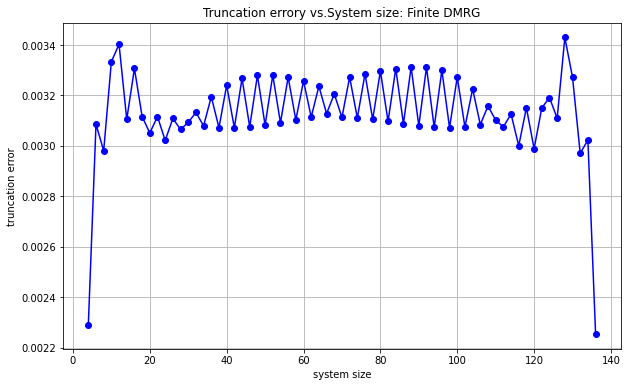

In [14]:
fig = plt.figure(figsize=(10,6))
plt.plot(System_Size,truncation_error,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('truncation error')
plt.title('Truncation errory vs.System size: Finite DMRG')
plt.grid('on')

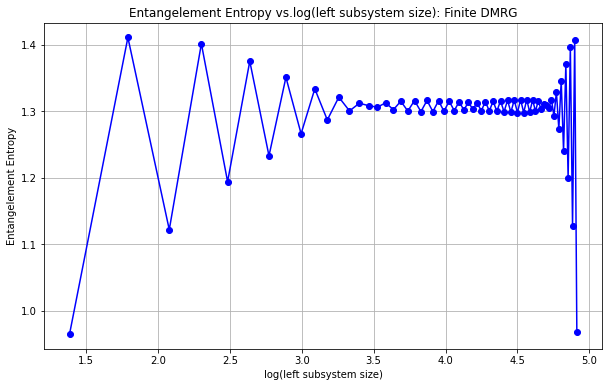

In [15]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(System_Size),EE,'o-',c='b')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Finite DMRG')
plt.grid('on')

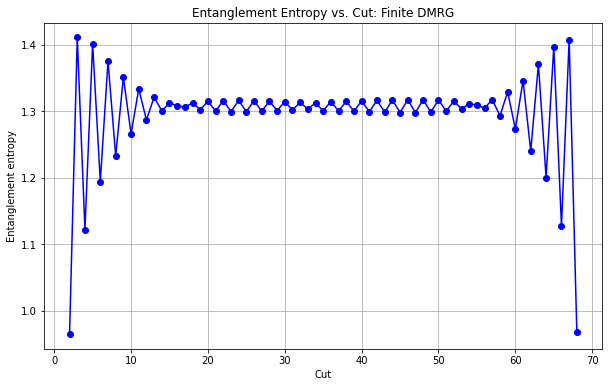

In [16]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='b')
plt.title('Entanglement Entropy vs. Cut: Finite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')

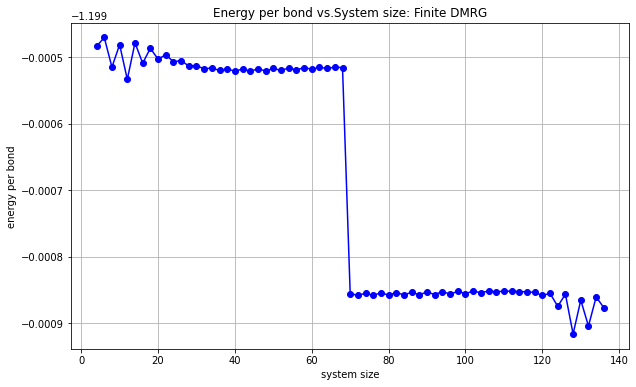

In [17]:
fig = plt.figure(figsize=(10,6))
plt.plot(System_Size,energy_per_bond,'o-',c='b')
plt.xlabel('system size')
plt.ylabel('energy per bond')
plt.title('Energy per bond vs.System size: Finite DMRG')
plt.grid('on')

## Considering system's symmetry

Now we want to preserve system's symmetry, meaning that the superblock hamiltonian should remain block-diagonal in every iteration and the number of up and down spins is conserved in the ground state wave function. (Hamiltonian Commutes with Number operator).\
For this purpose, we should Calculate number operator defined as $N_{up} + \lambda * N_{down}$ for left and right block, then we sort its diagonal values. After finding the sorted indices we can find the transformation which permutes all other operators with respect to this indices.\We build Hamiltonian with these permuted operators and it will be block-diagonal.\ Diagonalizing this hamiltonian with a proper initial vector for lancsoz algorithm will keep the ground state wave function in the desired basis so the reduced density matrix will also be block diagonal and the systems's symmetry in conserved in next iteration. This approach is much faster and the results are also more accurate.

In [18]:
bc = 0 #boundary condition
t = 1 #hopping term
U = 0.2
Lambda = 10**3

n_kept_states = 18 # Number of states kept

# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 44
system_size = 2*n_iter+2 #number of unitcells ( number of sites = 2*system_size)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 2 * 2  Operators in for single site
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Creation and Annihilation Operators:
C = csr(np.array([[0,1],[0,0]])) #annihilation operator -> sigma_minus
C_dag = csr(np.transpose(C))     #creation operator -> sigma_plus

# Number Operator:
n = C_dag*C

#Identity matrix
I_d = csr(np.eye(2))
I = csr(np.eye(4))

#Sigma_z
z = csr(np.array([[1,0],[0,-1]]))

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Each site is considered to be a unitcell that the left side is spin-down and the right side is spin-up

C_up = csr(kron(z,C))       #second site in unitcell
C_down = csr(kron(C,I_d))   #first site in unitcell

C_up_dag = csr.transpose(C_up)
C_down_dag = csr.transpose(C_down)

n_up = csr(kron(I_d,n))
n_down = csr(kron(n,I_d))

Z = kron(z,z)

# Operators for last site added to block 
#%%%%%%%%% Left %%%%%%%%%%%%
Cu_first_L = csr.copy(C_up)
Cud_first_L = csr.copy(C_up_dag)

Cd_first_L = csr.copy(C_down)
Cdd_first_L = csr.copy(C_down_dag)

n_up_last_L = csr.copy(n_up)
n_down_last_L = csr.copy(n_down)

block_Id_L  = csr.copy(I)
block_Z_L = csr.copy(Z)

#%%%%%%%%% Right %%%%%%%%%%%%
Cu_first_R = csr.copy(C_down)
Cud_first_R = csr.copy(C_down_dag)

Cd_first_R = csr.copy(C_up)
Cdd_first_R = csr.copy(C_up_dag)

n_up_last_R = csr.copy(n_down)
n_down_last_R = csr.copy(n_up)

block_Id_R  = csr.copy(I)
block_Z_R = csr.copy(Z)

# one site Hamiltonian
block_H_L = U*(n_up*n_down)

block_H_R = U*(n_down*n_up)

# Saving operators for finite dmrg

#%%%%% Left %%%%%%%
Cu_list_L = [];Cud_list_L = []

Cd_list_L = [];Cdd_list_L = []

block_H_list_L = []; block_Id_list_L = []; block_Z_list_L = []

Cu_list_L.append(Cu_first_L);Cud_list_L.append(Cud_first_L)

Cd_list_L.append(Cd_first_L);Cdd_list_L.append(Cdd_first_L)

block_H_list_L.append(block_H_L)
block_Id_list_L.append(block_Id_L)
block_Z_list_L.append(block_Z_L)

#%%%%%% Right %%%%%%
Cu_list_R = [];Cud_list_R = []

Cd_list_R = [];Cdd_list_R = []

block_H_list_R = []; block_Id_list_R = []; block_Z_list_R = []

Cu_list_R.append(Cu_first_R);Cud_list_R.append(Cud_first_R)

Cd_list_R.append(Cd_first_R);Cdd_list_R.append(Cdd_first_R)

block_H_list_R.append(block_H_R)
block_Id_list_R.append(block_Id_R)
block_Z_list_R.append(block_Z_R)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  initializing a few useful quantities
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

EE = np.zeros(n_iter) # Entanglement Entropy
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)
Check = np.zeros(n_iter) #Cheking that [H,N] = 0

#%%%%%%%%%%%%%%%%%%%%%%
#    Number Operator
#%%%%%%%%%%%%%%%%%%%%%%%
N_up_L = dict() ;N_down_L = dict()   
N_up_R = dict() ;N_down_R = dict() 
max_length_left_block = n_iter + 1

#Initializing
for x in range(max_length_left_block):
    if x==0:
        N_up_L[x] = n_up       
        N_down_L[x] = n_down
        N_up_R[x] = n_down
        N_down_R[x] = n_up
    else:
        N_up_L[x] = I 
        N_down_L[x] = I
        N_up_R[x] = I 
        N_down_R[x] = I

In [19]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Begin main iterations
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
spin_up = 1
spin_down = 1

start = timeit.default_timer()
for l in range(n_iter):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%%% Left Block Operators %%%%%%%%%%%
    n_up_last_L = kron (block_Id_L , n_up)
    n_down_last_L = kron (block_Id_L , n_down)
    
    Cu_last_L = kron (block_Z_L , C_up)         #C_up{i+1}
    Cud_last_L = kron (block_Z_L , C_up_dag)    #C_up{i+1}^\dag
    
    Cd_last_L = kron (block_Z_L , C_down)       #C_down{i+1}
    Cdd_last_L = kron (block_Z_L , C_down_dag)  #C_down{i+1}^\dag
    
    Cu_first_L = kron (Cu_first_L , I)   #C_up{i}
    Cud_first_L = kron (Cud_first_L , I) #C_up{i}^\dag 
    
    Cd_first_L = kron (Cd_first_L , I)   #C_down{i}
    Cdd_first_L = kron (Cdd_first_L , I) #C_down{i}^\dag
    
    #%%%%%%%%%%% Building left block hamiltonian %%%%%%%%%%%
    block_H_L = kron (block_H_L , I) + U * (n_up_last_L * n_down_last_L)\
    -t * ((Cud_last_L * Cu_first_L) + (Cud_first_L * Cu_last_L)\
        +(Cdd_last_L * Cd_first_L) + (Cdd_first_L * Cd_last_L))
    
    block_Id_L = kron (block_Id_L , I) 
    block_Z_L = kron (block_Z_L , Z)
    
    #%%%%%%%% Right Block Operators %%%%%%%%%%%%%%
    n_up_last_R = kron (block_Id_R , n_down)
    n_down_last_R = kron (block_Id_R , n_up)
    
    Cu_last_R = kron (block_Z_R , C_down)      #C_up{i+1}
    Cud_last_R = kron (block_Z_R , C_down_dag) #C_up{i+1}^\dag
    
    Cd_last_R = kron (block_Z_R , C_up)      #C_down{i+1}
    Cdd_last_R = kron (block_Z_R , C_up_dag) #C_down{i+1}^\dag
    
    Cu_first_R = kron (Cu_first_R , I)   #C_up{i}
    Cud_first_R = kron (Cud_first_R , I) #C_up{i}^\dag 
    
    Cd_first_R = kron (Cd_first_R , I)   #C_down{i}
    Cdd_first_R = kron (Cdd_first_R , I) #C_down{i}^\dag
    
    #%%%%%%%%%%%% Building right block hamiltonian %%%%%%%%%%
    block_H_R = kron (block_H_R , I) + U * (n_up_last_R * n_down_last_R)\
    -t * ((Cud_last_R * Cu_first_R) + (Cud_first_R * Cu_last_R)\
        +(Cdd_last_R * Cd_first_R) + (Cdd_first_R * Cd_last_R))
                    
    block_Id_R = kron (block_Id_R , I) 
    block_Z_R = kron (block_Z_R , Z)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #       Number operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    left_block_length = l + 1
    for x in range(max_length_left_block):
        # if x == left_block_length then a unitcell of two sites(spin-up and spin-down) is added
        if x == left_block_length:
            N_up_L[x] = kron(N_up_L[x],n_up)
            N_down_L[x] = kron(N_down_L[x],n_down)
            N_up_R[x] = kron(N_up_R[x],n_down)
            N_down_R[x] = kron(N_down_R[x],n_up)
            
        #elif left_block_length < max_length_left_block:
        else:   
            N_up_L[x] = kron(N_up_L[x],I)
            N_down_L[x] = kron(N_down_L[x],I)
            N_up_R[x] = kron(N_up_R[x],I)
            N_down_R[x] = kron(N_down_R[x],I)
        
    dim_n = np.size(N_up_L[0],axis=1)
    
    #Total number operator for left and right block:
    N_Left = csr((dim_n,dim_n)) 
    N_Right = csr((dim_n,dim_n))
    
    for i in range(left_block_length+1):
        N_Left += N_up_L[i] + Lambda*N_down_L[i]
        N_Right += N_up_R[i] + Lambda*N_down_R[i]

    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Sorting Numper operator and finding the desired transformation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    NL_diag = np.diag(N_Left.todense())
    sort_L  = np.argsort(NL_diag) #indices after sorting N_Left_diag
    
    UL = lil((dim_n, dim_n)) #Transformation matrix for left block
    for i in range(dim_n):
        UL[sort_L[i], i] = 1
    UL_dag = lil.transpose(UL)
    
    #%%%%%%%%% Right %%%%%%%%%%%   
    NR_diag = np.diag(N_Right.todense())
    sort_R  = np.argsort(NR_diag) #indices after sorting N_Right_diag
    
    UR = lil((dim_n, dim_n)) #Transformation matrix for right block
    for i in range(dim_n):
        UR[sort_R[i], i] = 1
    UR_dag = lil.transpose(UR)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Permutation for left and right block operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    block_H_L = UL_dag*block_H_L*UL
    
    Cu_last_L = UL_dag*Cu_last_L*UL
    Cud_last_L = UL_dag*Cud_last_L*UL
    
    Cd_last_L = UL_dag*Cd_last_L*UL
    Cdd_last_L = UL_dag*Cdd_last_L*UL
    
    block_Id_L = UL_dag*block_Id_L*UL
    block_Z_L = UL_dag*block_Z_L*UL
    
    N_Left = UL_dag*N_Left*UL #Permuted Number operator for left block
    
    #%%%%%%%%% Right %%%%%%%%%%%  
    block_H_R = UR_dag*block_H_R*UR
    
    Cu_last_R = UR_dag*Cu_last_R*UR
    Cud_last_R = UR_dag*Cud_last_R*UR
    
    Cd_last_R = UR_dag*Cd_last_R*UR
    Cdd_last_R = UR_dag*Cdd_last_R*UR
    
    block_Id_R = UR_dag*block_Id_R*UR
    block_Z_R = UR_dag*block_Z_R*UR
    
    N_Right = UR_dag*N_Right*UR #Permuted Number operator for right block
    
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    #%%%%%%%%%% Left %%%%%%%%%%%    
    C_up_L = kron(Cu_last_L,block_Id_R)
    C_up_dag_L = kron(Cud_last_L,block_Id_R) 
        
    C_down_L = kron(Cd_last_L,block_Id_R)
    C_down_dag_L = kron(Cdd_last_L,block_Id_R) 
    
    block_H_Left = kron(block_H_L,block_Id_R)
    
    #%%%%%%%%% Right %%%%%%%%%%%     
    C_up_R = kron(block_Id_L,Cu_last_R)
    C_up_dag_R = kron(block_Id_L,Cud_last_R)
    
    C_down_R = kron(block_Id_L,Cd_last_R)
    C_down_dag_R = kron(block_Id_L,Cdd_last_R) 
    
    block_H_Right = kron(block_Id_L,block_H_R) 
    
    #%%%%%%%%% Superblock %%%%%%%%%%%
    H_superblock = csr(block_H_Right + block_H_Left)\
        - t*csr(((C_up_dag_L*C_up_R)+(C_up_dag_R*C_up_L) + (C_down_dag_L*C_down_R)+(C_down_dag_R*C_down_L)))
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2 #Making sure that Hamiltonian is hermitian  
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Diagonalizing the Hamiltonian with Lancsoz algorithm
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    N_TOT = kron(N_Left,block_Id_R) + kron(block_Id_L,N_Right) #Total Number operator in the permuted space
    N_values = np.diag(N_TOT.todense())  
    
    #Counting spins in half-filling
    spin_up +=1
    spin_down +=1
    
    N_spins = spin_up + Lambda*spin_down #Total number of spins
    
    indeces = np.where(N_values == N_spins) #Index of the numbers in diagonal Number operator equal to total number of spins
    
    if len (indeces[0]) == 0:
        Exact = "NO"
        difference = N_values - N_spins
        new_indices = np.where(difference == difference.min())  #If not finding it exactly, then chosing the nearest number
        Index = new_indices[0][0]
    else:
        Exact = "YES"
        Index = indeces[0][0]
    
    dim_N = np.size(H_superblock,axis=1)
    Lancsoz_vec = np.zeros(dim_N) #Initial lan
    Lancsoz_vec[Index] = 1
    Lancsoz_vec = Lancsoz_vec/np.linalg.norm(Lancsoz_vec)
    
    Energy,Psi = eigsh(H_superblock, k = 1, v0 = Lancsoz_vec, which = 'SA') #diagonalization with lancsoz
    energy = Energy #Ground state wafe function
    
    energy_per_bond[l] = energy/(2*(l+1) + 2)
    system_size[l] = 2*(l+2)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Form the reduced density matrix
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    dim_block = np.size(block_H_L,axis=1)
    Psi_matrix = csr(np.reshape(Psi,(dim_block, dim_block)))
    
    Rho_L = Psi_matrix * csr.transpose(Psi_matrix) #Reduced density  matrix for left block
    Rho_R = csr.transpose(Psi_matrix) * Psi_matrix #Reduced density matrix for right block
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    n_kept_temp = min(dim_block, n_kept_states)
    
    D_L, V_L = LA.eigh(Rho_L.todense())
    sort_ind_L = np.argsort(D_L)[::-1] #sorting eigen values in descending order
    D_L = D_L[sort_ind_L]
    V_L = V_L[:, sort_ind_L] #corresponding eigen vectors
    
    D_R, V_R = LA.eigh(Rho_R.todense())
    sort_ind_R = np.argsort(D_R)[::-1] #sorting eigen values in descending order
    D_R = D_R[sort_ind_R]
    V_R = V_R[:, sort_ind_R] #corresponding eigen vectors
    
    ES = D_L
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Construct the truncation operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Trunc_L = csr(V_L[:, :n_kept_temp]) #Left block operators truncation
    Trunc_L_dag = csr.transpose(Trunc_L)
    
    Trunc_R = csr(V_R[:, :n_kept_temp])
    Trunc_R_dag = csr.transpose(Trunc_R) #Right block operators truncation

    truncation_error[l] = 1 - sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f\t Exact:%s\t ' %(l, energy, energy_per_bond[l], truncation_error[l],Exact))
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Transform the block operators into the truncated basis
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    block_H_L  = Trunc_L_dag*block_H_L*Trunc_L
        
    Cu_last_L  = Trunc_L_dag*Cu_last_L*Trunc_L
    Cud_last_L = Trunc_L_dag*Cud_last_L*Trunc_L
        
    Cd_last_L = Trunc_L_dag*Cd_last_L*Trunc_L
    Cdd_last_L = Trunc_L_dag*Cdd_last_L*Trunc_L
        
    block_Id_L = Trunc_L_dag*block_Id_L*Trunc_L
    block_Z_L = Trunc_L_dag*block_Z_L*Trunc_L
    
    # For next iteration:
    Cu_first_L = csr.copy(Cu_last_L)   #C_up{i} --> C_up{i+1}
    Cud_first_L = csr.copy(Cud_last_L) #C_up{i}^\dag --> C_up{i+1}^\dag 
    
    Cd_first_L = csr.copy(Cd_last_L)   #C_down{i} --> C_down{i+1}
    Cdd_first_L = csr.copy(Cdd_last_L) #C_down{i}^\dag --> C_down{i+1}^\dag
    
    #%%%%%%%%% Right %%%%%%%%%%%    
    block_H_R  = Trunc_R_dag*block_H_R*Trunc_R
        
    Cu_last_R  = Trunc_R_dag*Cu_last_R*Trunc_R
    Cud_last_R = Trunc_R_dag*Cud_last_R*Trunc_R
        
    Cd_last_R = Trunc_R_dag*Cd_last_R*Trunc_R
    Cdd_last_R = Trunc_R_dag*Cdd_last_R*Trunc_R
        
    block_Id_R = Trunc_R_dag*block_Id_R*Trunc_R
    block_Z_R = Trunc_R_dag*block_Z_R*Trunc_R
    
    # For next iteration:
    Cu_first_R = csr.copy(Cu_last_R)   #C_up{i} --> C_up{i+1}
    Cud_first_R = csr.copy(Cud_last_R) #C_up{i}^\dag --> C_up{i+1}^\dag
    
    Cd_first_R = csr.copy(Cd_last_R)   #C_down{i} --> C_down{i+1}
    Cdd_first_R = csr.copy(Cdd_last_R) #C_down{i}^\dag --> C_down{i+1}^\dag
    
    #%%%%%%%%% Truncation for N_up{i} and N_down{i} %%%%%%%%
    T_L = UL * Trunc_L; T_L_dag = csr.transpose(T_L)
    T_R = UR * Trunc_R; T_R_dag = csr.transpose(T_R)
    
    for i in range(max_length_left_block): 
        N_up_L[i] = T_L_dag*N_up_L[i]*T_L
        N_down_L[i] = T_L_dag*N_down_L[i]*T_L
        
        N_up_R[i] = T_R_dag*N_up_R[i]*T_R
        N_down_R[i] = T_R_dag*N_down_R[i]*T_R
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Saving Operator for finite DMRG
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    Cu_list_L.append(Cu_first_L)
    Cud_list_L.append(Cud_first_L)

    Cd_list_L.append(Cd_first_L)
    Cdd_list_L.append(Cdd_first_L)

    block_H_list_L.append(block_H_L)
    block_Id_list_L.append(block_Id_L)
    
    block_Z_list_L.append(block_Z_L)
    
    #%%%%%%%%%% Right %%%%%%%%%%% 
    Cu_list_R.append(Cu_first_R);
    Cud_list_R.append(Cud_first_R)

    Cd_list_R.append(Cd_first_R);
    Cdd_list_R.append(Cdd_first_R)

    block_H_list_R.append(block_H_R)
    block_Id_list_R.append(block_Id_R)
    
    block_Z_list_R.append(block_Z_R)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 0	 total_En: -4.2763	 En_per_bound: -1.0691	 trunErr: -0.0000	 Exact:YES	 
iter: 1	 total_En: -6.6936	 En_per_bound: -1.1156	 trunErr: 0.0009	 Exact:YES	 
iter: 2	 total_En: -9.1150	 En_per_bound: -1.1394	 trunErr: 0.0000	 Exact:YES	 
iter: 3	 total_En: -11.5497	 En_per_bound: -1.1550	 trunErr: 0.0016	 Exact:YES	 
iter: 4	 total_En: -13.9769	 En_per_bound: -1.1647	 trunErr: 0.0002	 Exact:YES	 
iter: 5	 total_En: -16.4150	 En_per_bound: -1.1725	 trunErr: 0.0017	 Exact:YES	 
iter: 6	 total_En: -18.8443	 En_per_bound: -1.1778	 trunErr: 0.0003	 Exact:YES	 
iter: 7	 total_En: -21.2825	 En_per_bound: -1.1824	 trunErr: 0.0017	 Exact:YES	 
iter: 8	 total_En: -23.7131	 En_per_bound: -1.1857	 trunErr: 0.0004	 Exact:YES	 
iter: 9	 total_En: -26.1515	 En_per_bound: -1.1887	 trunErr: 0.0016	 Exact:YES	 
iter: 10	 total_En: -28.5829	 En_per_bound: -1.1910	 trunErr: 0.0004	 Exact:YES	 
iter: 11	 total_En: -31.0213	 En_per_bound: -1.1931	 trunErr: 0.0016	 Exact:YES	 
iter: 12	 total_En: -33.4533

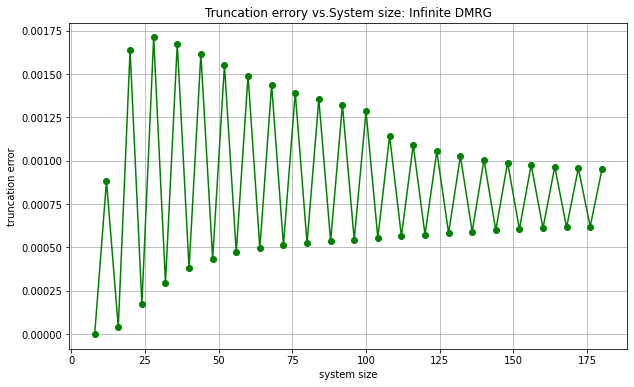

In [21]:
fig = plt.figure(figsize=(10,6))
plt.plot(2*system_size,truncation_error,'o-',c='g')
plt.xlabel('system size')
plt.ylabel('truncation error')
plt.title('Truncation errory vs.System size: Infinite DMRG')
plt.grid('on')

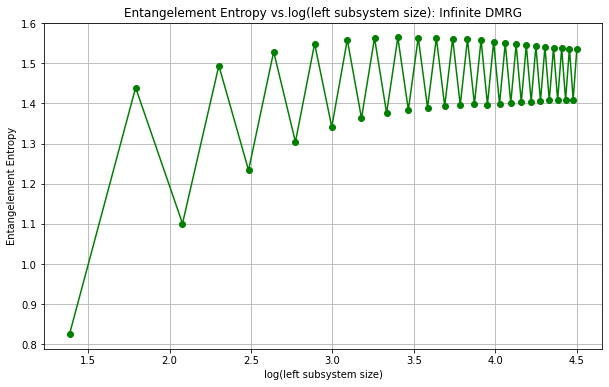

In [22]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(system_size),EE,'o-',c='g')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Infinite DMRG')
plt.grid('on')

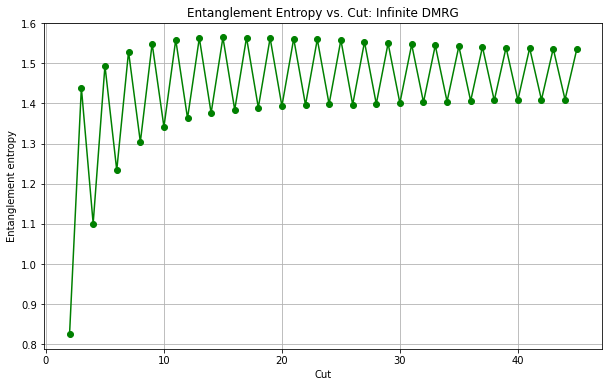

In [23]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='g')
plt.title('Entanglement Entropy vs. Cut: Infinite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')

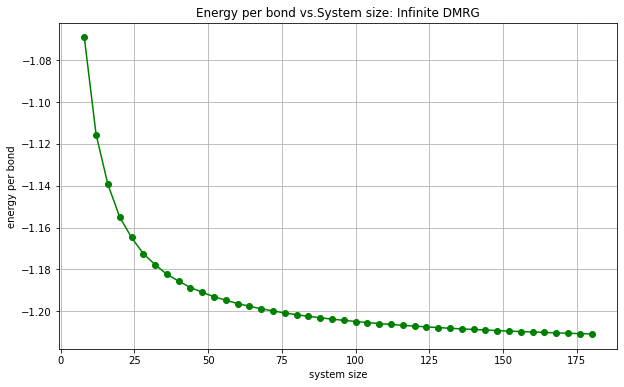

In [24]:
fig = plt.figure(figsize=(10,6))
plt.plot(2*system_size,energy_per_bond,'o-',c='g')
plt.xlabel('system size')
plt.ylabel('energy per bond')
plt.title('Energy per bond vs.System size: Infinite DMRG')
plt.grid('on')

# Spins separated in left and right block

In [25]:
bc = 0 #boundary condition
t = 1
U = 0.2

n_kept_states = 20 # Number of states kept


# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 24
system_size = 2*n_iter+2


###########################################################
# Operators in 2 dimensional hilbert space for single site
###########################################################

# Creation and Annihilation Operators:
C = csr(np.array([[0,0],[1,0]])) #annihilation operator -> sigma_minus
C_dag = csr(np.transpose(C)) #creation operator -> sigma_plus

# Number Operator:
n = C_dag*C

#Identity matrix
I = csr(np.eye(2))


############################################################################
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
############################################################################
# Operators for last site added to block 

block_C_last = C
block_C_dag_last = C_dag

block_n_last = n

block_Id  = I

# one site Hamiltonian
block_H = np.zeros((2,2))

# initializing a few useful quantities:
EE = np.zeros(n_iter)
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)

# Saving operators for finite dmrg

block_C_list = []
block_C_dag_list = []

block_H_list = []
block_Id_list = []

block_C_list.append(block_C_last)
block_C_dag_list.append(block_C_dag_last)


block_H_list.append(block_H)
block_Id_list.append(block_Id)


n_list = []
n_list.append(n)

In [26]:
###############################
#   Begin main iterations
###############################

start = timeit.default_timer()
for l in range(1,n_iter+1):
    
    ##################################################################
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    ##################################################################
    
    block_n_last = kron(block_Id,n)

    block_H = kron(block_H,I)-t*(kron(block_C_dag_last,C) + kron(block_C_last,C_dag))
    
        
    block_C_last = kron(block_Id,C)
    block_C_dag_last = kron(block_Id,C_dag)
    
    block_Id = kron(block_Id,I)
    
    #constructing number operators
    for i in range(len(n_list)):
        n_list[i] = kron(n_list[i],I)
        
    n_list.append(block_n_last)

    dim_H = np.size(kron(block_H,block_Id),axis=1)
    Interaction = csr(np.zeros((dim_H,dim_H)))
    
    for i in range(len(n_list)):
        Interaction += U*kron(n_list[i],n_list[i])

    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    H_superblock = csr(kron(block_H,block_Id) + kron(block_Id, block_H)) + Interaction
    
    H_superblock = (H_superblock + csr.transpose(H_superblock))/2  
    
    #########################################
    #    Diagonalizing the Hamiltonian
    ##########################################
    
    Energy,Psi = eigsh(H_superblock,k = 1, which = 'SA')
    energy = Energy[0]
    energy_per_bond[l-1] = energy/((l * 2 + 2)/2)
    system_size[l-1] = 2*(l+1)
    
    ##########################################
    #   Form the reduced density matrix
    ##########################################
    
    dim_block = np.size(block_H,axis=1)
    Psi_matrix = np.reshape(Psi,(dim_block, dim_block))
    block_Rho = np.matmul(Psi_matrix,np.transpose(Psi_matrix))
    
    #########################################################################
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #########################################################################
    
    n_kept_temp = min(dim_block, n_kept_states)
    D, V = LA.eigh(block_Rho)
    sort_ind = np.argsort(D)[::-1]
    V = V[:, sort_ind] 
    D = D[sort_ind]
    ES = D
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l-1] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    ######################################
    #  Construct the truncation operator
    ######################################
    
    block_T = V[:, :n_kept_temp]
    block_T = csr(block_T)
    block_T_dag = csr.transpose(block_T)

    truncation_error[l-1] = 1 - sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f' %(l, energy, energy_per_bond[l-1], truncation_error[l-1]))
    
    #############################################################
    #   Transform the block operators into the truncated basis
    #############################################################
    
    if l < n_iter:
        block_H  = block_T_dag*block_H*block_T
        
        block_C_last  = block_T_dag*block_C_last*block_T
        
        block_C_dag_last = block_T_dag*block_C_dag_last*block_T
        
        block_Id = block_T_dag*block_Id*block_T
        
        block_n_last = block_T_dag*block_n_last*block_T
        
        for i in range(len(n_list)):
            n_list[i] = block_T_dag*n_list[i]*block_T

    ######################
    # Saving operators
    ######################
    
    block_C_list.append(block_C_last)
    block_C_dag_list.append(block_C_dag_last)

    block_H_list.append(block_H)
    block_Id_list.append(block_Id)
    
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

iter: 1	 total_En: -1.9025	 En_per_bound: -0.9512	 trunErr: -0.0000
iter: 2	 total_En: -2.7557	 En_per_bound: -0.9186	 trunErr: -0.0000
iter: 3	 total_En: -4.2763	 En_per_bound: -1.0691	 trunErr: -0.0000
iter: 4	 total_En: -5.3015	 En_per_bound: -1.0603	 trunErr: -0.0000
iter: 5	 total_En: -6.6816	 En_per_bound: -1.1136	 trunErr: 0.0000
iter: 6	 total_En: -6.7900	 En_per_bound: -0.9700	 trunErr: 0.0000
iter: 7	 total_En: -8.6474	 En_per_bound: -1.0809	 trunErr: 0.0000
iter: 8	 total_En: -8.6515	 En_per_bound: -0.9613	 trunErr: 0.0000
iter: 9	 total_En: -10.5507	 En_per_bound: -1.0551	 trunErr: 0.0000
iter: 10	 total_En: -10.5541	 En_per_bound: -0.9595	 trunErr: 0.0000
iter: 11	 total_En: -12.4533	 En_per_bound: -1.0378	 trunErr: 0.0000
iter: 12	 total_En: -12.4566	 En_per_bound: -0.9582	 trunErr: 0.0000
iter: 13	 total_En: -14.3558	 En_per_bound: -1.0254	 trunErr: 0.0000
iter: 14	 total_En: -14.3591	 En_per_bound: -0.9573	 trunErr: 0.0000
iter: 15	 total_En: -16.2582	 En_per_bound: -1.

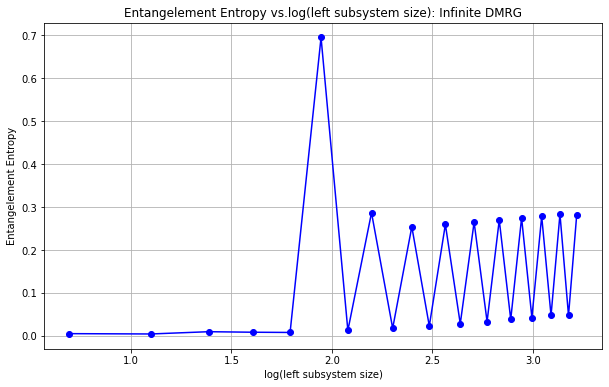

In [27]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.log(system_size/2),EE,'o-',c='b')
plt.xlabel('log(left subsystem size)')
plt.ylabel('Entangelement Entropy')
plt.title('Entangelement Entropy vs.log(left subsystem size): Infinite DMRG')
plt.grid('on')

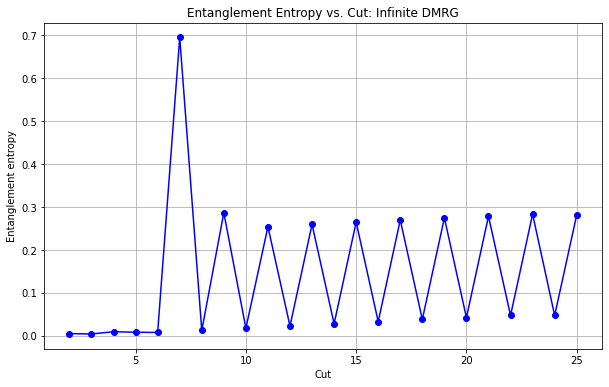

In [28]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(2,len(EE)+2), EE,'o-',c='b')
plt.title('Entanglement Entropy vs. Cut: Infinite DMRG')
plt.xlabel('Cut')
plt.ylabel('Entanglement entropy')
plt.grid('on')